In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t as tdist
sns.set(style='whitegrid', context='talk')

In [55]:
# === LOAD DATA ===
df = pd.read_csv(r'data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Compute risk-free rate (monthly) and lag
rf = df['TB1M']/100/365
rf_lag = rf.shift(1)

# Remove RF column from price data
prices = df.drop(columns=['TB1M'])

# Simple returns
returns = prices / prices.shift(1) - 1

# Risk premia
RP = returns.sub(rf_lag, axis=0).rename(columns={'OEX':'OEX_rp'})

# Drop NA
RP_aligned = RP.dropna(how='any')

RP_aligned.head()
# print(RP_aligned['OEX_rp'].mean())

,OEX_rp,AAPL,ABT,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.037904,-0.084460,-0.028721,-0.084040,-0.051263,-0.056602,-0.076615,-0.010811,-0.083367,-0.037909,...,-0.037650,-0.042678,-0.012941,-0.001602,-0.031837,-0.036624,-0.032475,-0.049671,-0.037568,-0.019304
2000-01-05,0.003158,0.014484,-0.001987,0.019622,0.002228,0.025492,0.034260,0.030024,-0.148890,-0.025547,...,0.008509,-0.024260,-0.002504,-0.000149,0.047012,-0.022231,0.033256,-0.010233,-0.020557,0.054367
2000-01-06,0.001322,-0.086687,0.034842,0.008014,0.030355,0.066518,0.016483,-0.010609,-0.060185,0.020224,...,-0.000149,-0.027457,0.036451,0.060898,-0.000149,0.077270,-0.005229,0.043993,0.010764,0.051549
2000-01-07,0.027191,0.047221,0.010528,0.048435,0.074699,0.015477,0.112326,0.054820,0.060862,0.014411,...,0.012727,0.005199,0.117164,-0.006998,-0.024045,0.038774,-0.007532,0.017738,0.075416,-0.003083
2000-01-10,0.009336,-0.017736,-0.007190,0.038463,-0.017842,0.076776,0.060514,0.088029,-0.005538,0.013793,...,-0.008622,0.068337,-0.017477,0.023301,0.010211,-0.005911,-0.005461,-0.032097,-0.018396,-0.014129


In [29]:
def excel_first_pass(RP,start,end):
    RP=RP.loc[start:end]
    RM=RP['OEX_rp']
    rows=[]
    for s in RP.columns:
        if s=='OEX_rp': continue
        Ri=RP[s]
        cov=np.cov(Ri,RM)[0,1]
        var=np.var(RM,ddof=1)
        beta=cov/var
        alpha=Ri.mean()-beta*RM.mean()
        sigma2=np.var(Ri-beta*RM)
        rows.append([s,beta,alpha,sigma2,Ri.mean()])
    return pd.DataFrame(rows,columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

first = excel_first_pass(RP_aligned,'2000-03-31','2023-01-31')
print(first)

valid=first.set_index('Ticker')
y=valid['riskprem_mean']
X1=sm.add_constant(valid[['beta']])
model1=sm.OLS(y,X1).fit()
X2=sm.add_constant(valid[['beta','sigma2']])
model2=sm.OLS(y,X2).fit()
from IPython.display import display
display(model1.summary())
display(model2.summary())

   Ticker      beta     alpha    sigma2  riskprem_mean
0    AAPL  1.161092  0.000948  0.000404       0.001153
1     ABT  0.647330  0.000403  0.000167       0.000518
2    ADBE  1.338736  0.000535  0.000428       0.000772
3     AIG  1.437751 -0.000110  0.000955       0.000144
4     AMD  1.577049  0.000608  0.001157       0.000887
..    ...       ...       ...       ...            ...
75    USB  1.112439  0.000254  0.000266       0.000451
76     VZ  0.665516  0.000086  0.000153       0.000204
77    WFC  1.255505  0.000286  0.000342       0.000508
78    WMT  0.612115  0.000184  0.000154       0.000292
79    XOM  0.847077  0.000260  0.000166       0.000410

[80 rows x 5 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.074
Date:                Sat, 06 Dec 2025   Prob (F-statistic):             0.0470
Time:                        11:22:48   Log-Likelihood:                 554.23
No. Observations:                  80   AIC:                            -1104.
Df Residuals:                      78   BIC:                            -1100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   8.84e-05      4.131      0.000       0.000       0.001
beta           0.0002   8.59e-05      2.018      0.047    2.37e-06       0.000
==============================================================================
Omnibus:                        9.266   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.016
Skew:                           0.612   Prob(JB):                      0.00669
Kurtosis:                       4.228   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     10.29
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           0.000110
Time:                        11:22:48   Log-Likelihood:                 561.67
No. Observations:                  80   AIC:                            -1117.
Df Residuals:                      77   BIC:                            -1110.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   8.37e-05      5.347      0.000       0.000       0.001
beta       -9.142e-05      0.000     -0.885      0.379      -0.000       0.000
sigma2         0.6014      0.152      3.967      0.000       0.299       0.903
==============================================================================
Omnibus:                        5.775   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                8.982
Skew:                          -0.022   Prob(JB):                       0.0112
Kurtosis:                       4.641   Cond. No.                     8.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
print('=== CAPM HYPOTHESIS TESTS ===')
market_rp = RP_aligned['OEX_rp'].mean()
n = valid.shape[0]

# Model 1
gamma1_1 = model1.params['beta']
se1 = model1.bse['beta']
df1 = n - 2
t1 = (gamma1_1 - market_rp)/se1
p1 = 2*(1 - tdist.cdf(abs(t1), df1))
print('\nModel 1 (beta only)')
print('gamma1 =',gamma1_1)
print('market rp =',market_rp)
print('t-stat =',t1)
print('p-value =',p1)

# Model 2
gamma1_2 = model2.params['beta']
se2 = model2.bse['beta']
df2 = n - 3
t2 = (gamma1_2 - market_rp)/se2
p2 = 2*(1 - tdist.cdf(abs(t2), df2))
print('\nModel 2 (beta + sigma2)')
print('gamma1 =',gamma1_2)
print('market rp =',market_rp)
print('t-stat =',t2)
print('p-value =',p2)

=== CAPM HYPOTHESIS TESTS ===

Model 1 (beta only)
gamma1 = 0.0005459005575071627
market rp = 0.0002498301994684808
t-stat = 2.8232168736765937
p-value = 0.006031082731742465

Model 2 (beta + sigma2)
gamma1 = 0.00038642793356472623
market rp = 0.0002498301994684808
t-stat = 1.1254243962211448
p-value = 0.26390496762572857


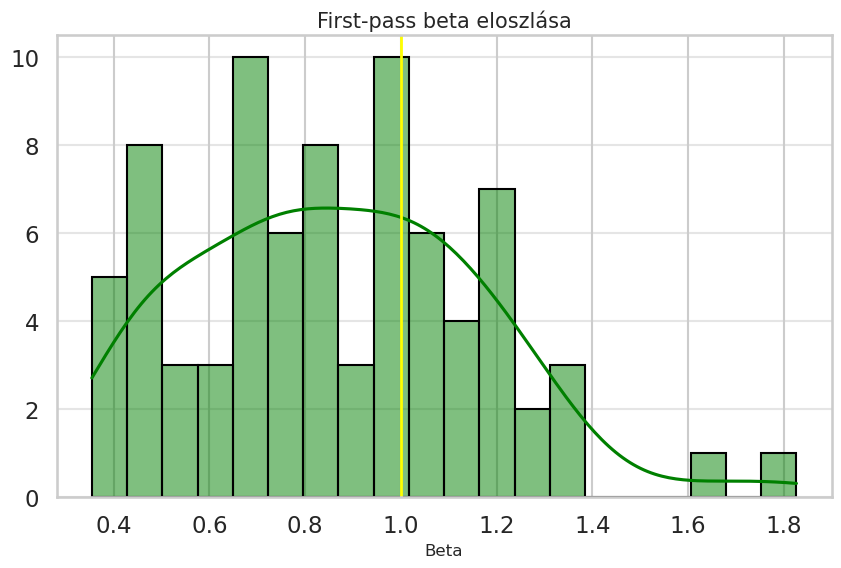

First-pass regresszió eredményei (első 5 sor):
  Ticker      beta     alpha    sigma2  riskprem_mean
0   AAPL  1.219753  0.000295  0.000136       0.001043
1    ABT  0.654670 -0.000032  0.000182       0.000369
2   ADBE  1.226409 -0.000516  0.000293       0.000236
3    AIG  1.043118 -0.000023  0.000382       0.000617
4    AMD  1.638670  0.000665  0.000658       0.001670


In [53]:
first_pass_results = excel_first_pass(RP_aligned, '2020-01-01', '2025-11-01')

# Hisztogram készítése
plt.figure(figsize=(10, 6))
sns.histplot(data=first_pass_results, x='beta', bins=20, kde=True, color='green', edgecolor='black')

# Díszítés
plt.title('First-pass beta eloszlása', fontsize=15)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('')
plt.axvline(x=1, color='yellow', linewidth=2)
plt.grid(axis='y', alpha=0.5)
plt.savefig('src/betaeloszl.svg')
plt.show()

# Eredmények kiírása ellenőrzésképp
print("First-pass regresszió eredményei (első 5 sor):")
print(first_pass_results.head())

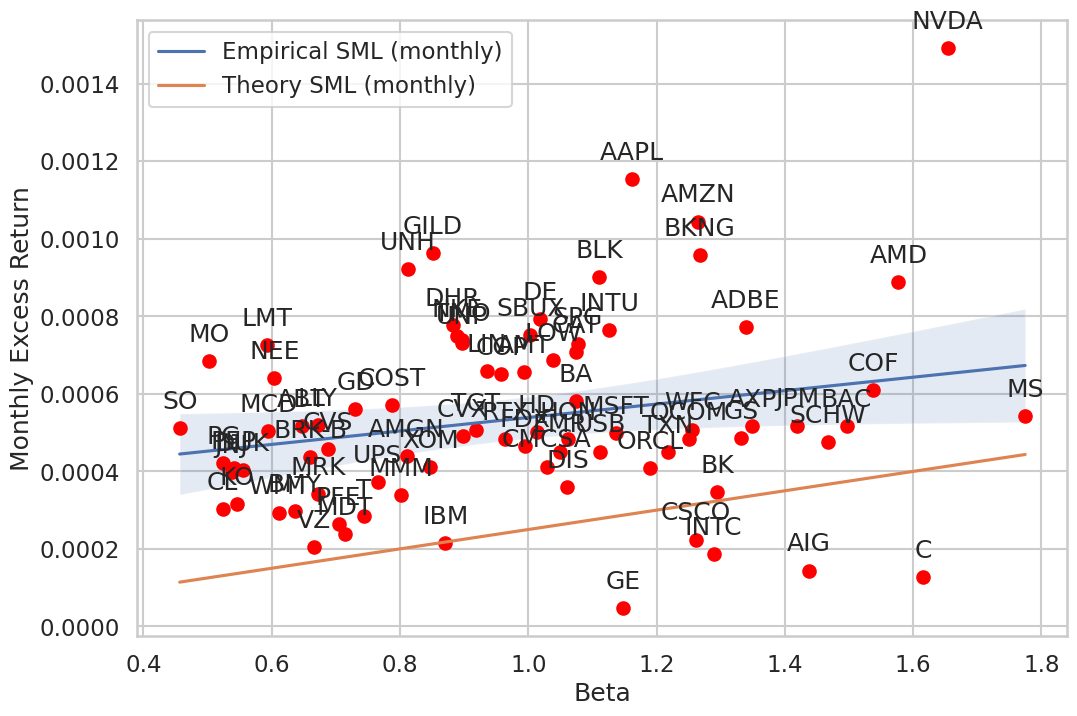

In [33]:
betas=valid['beta']; y_m=valid['riskprem_mean']
beta_grid=np.linspace(betas.min(), betas.max(),200)
X_pred=sm.add_constant(beta_grid)
pred=model1.get_prediction(X_pred)
ci=pred.conf_int(); y_pred=pred.predicted_mean
lower,upper=ci[:,0],ci[:,1]
plt.figure(figsize=(12,8))
plt.plot(beta_grid,y_pred,label='Empirical SML (monthly)')
plt.fill_between(beta_grid,lower,upper,alpha=0.15)
plt.plot(beta_grid,RP_aligned['OEX_rp'].mean()*beta_grid,label='Theory SML (monthly)')
plt.scatter(betas,y_m,color='red')
for t in betas.index: plt.text(betas[t],y_m[t]+0.0001,t,ha='center')
plt.xlabel('Beta'); plt.ylabel('Monthly Excess Return'); plt.legend(); plt.show()

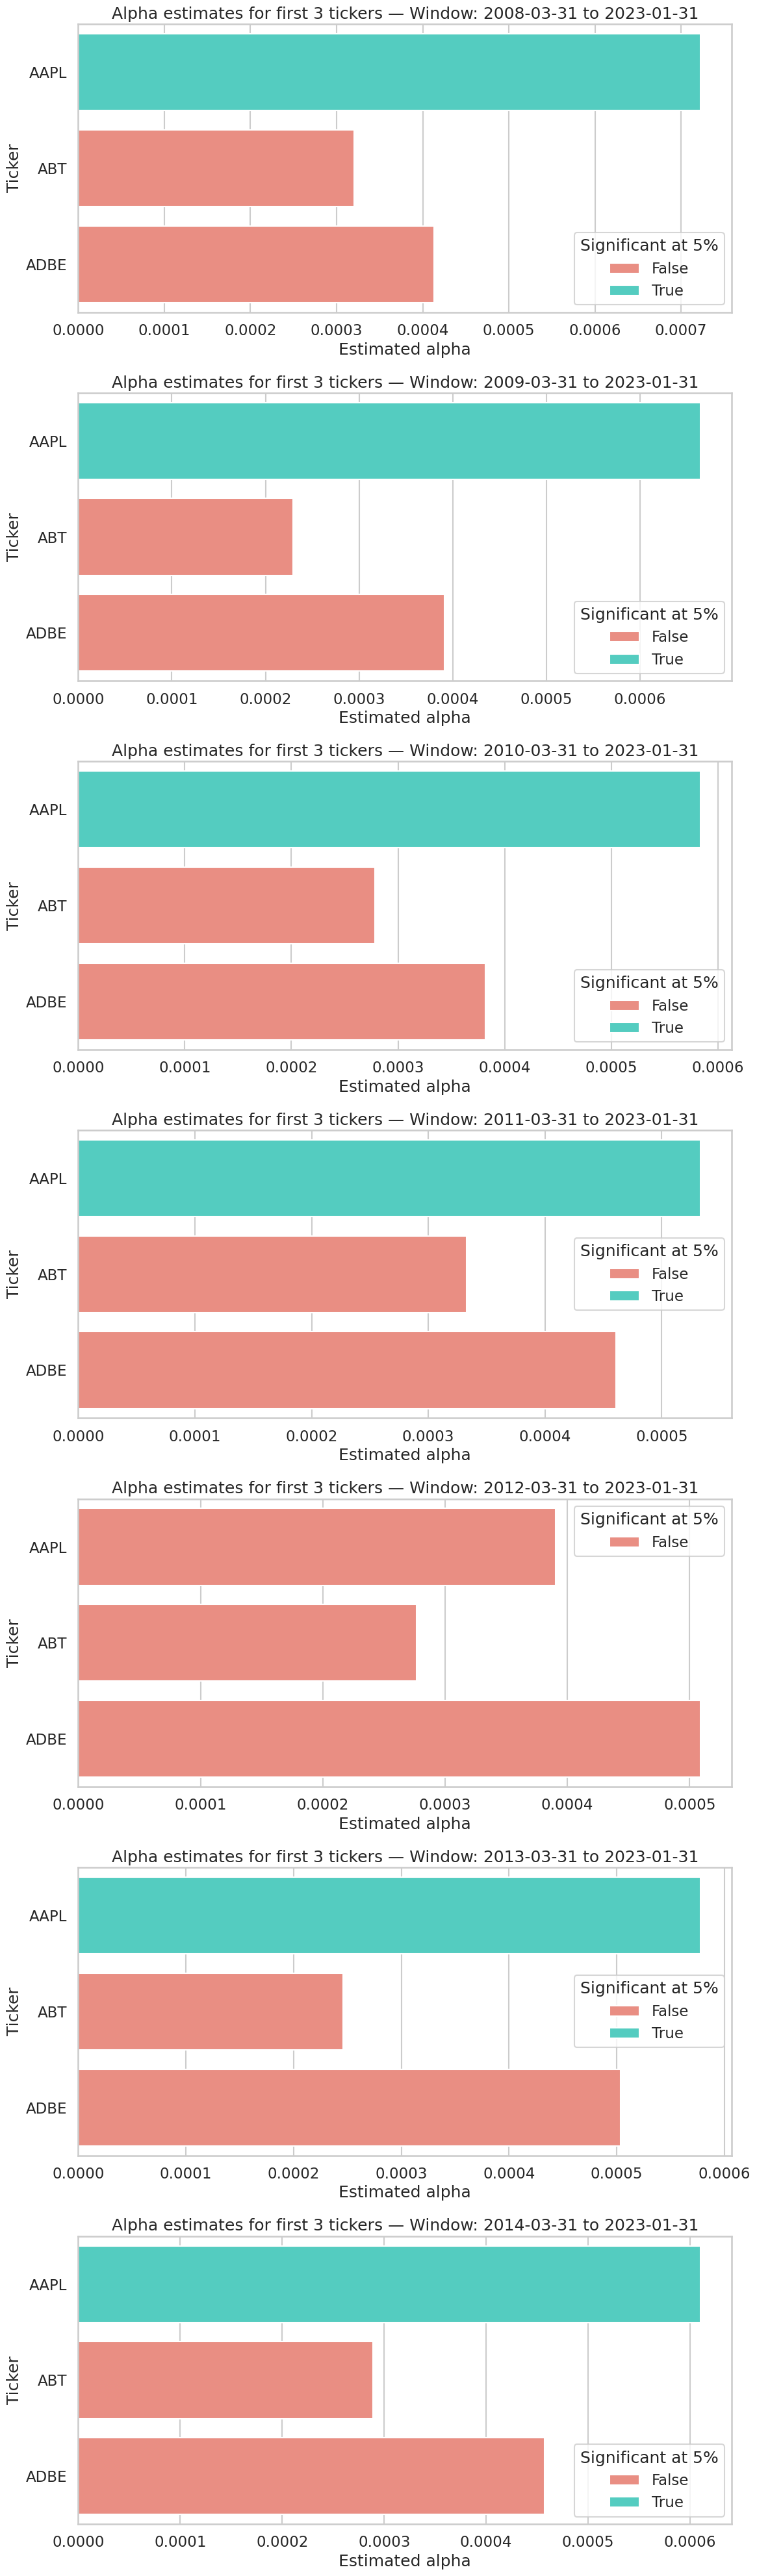

In [61]:
# === MULTI-WINDOW ANALYSIS ===

END = "2023-01-31"
starts = [
    "2008-03-31","2009-03-31","2010-03-31",
    "2011-03-31","2012-03-31","2013-03-31","2014-03-31"
]

fig, axes = plt.subplots(7, 1, figsize=(12, 40))
plt.subplots_adjust(hspace=0.5)

for idx, start in enumerate(starts):
    first = excel_first_pass(RP_aligned, start, END)
    first = first.dropna()

    # Select first 3 tickers
    top3 = first.iloc[:3].copy()

    RM = RP_aligned['OEX_rp'].loc[start:END]
    RM_mean = RM.mean()
    RM_var = RM.var(ddof=1)
    N = len(RM)

    # Alpha SE
    top3['alpha_se'] = np.sqrt(top3['sigma2'] * (1 + (RM_mean**2)/RM_var) / N)

    # t-stats and p-values
    top3['tstat'] = top3['alpha'] / top3['alpha_se']
    top3['pval'] = 2 * (1 - tdist.cdf(np.abs(top3['tstat']), df=N-2))
    top3['significant'] = top3['pval'] < 0.05

    ax = axes[idx]
    sns.barplot(
        data=top3,
        x='alpha',
        y='Ticker',
        hue='significant',
        palette={True:'turquoise', False:'salmon'},
        ax=ax
    )

    ax.set_title(f"Alpha estimates for first 3 tickers — Window: {start} to {END}")
    ax.set_xlabel("Estimated alpha")
    ax.set_ylabel("Ticker")
    ax.legend(title="Significant at 5%")

plt.tight_layout()
#plt.show()

In [62]:
# === FIRST PASS FUNCTION ===
def excel_first_pass(RP, start, end):
    RPsub = RP.loc[start:end]
    RM = RPsub['OEX_rp']
    rows = []
    for s in RPsub.columns:
        if s == 'OEX_rp':
            continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta * RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

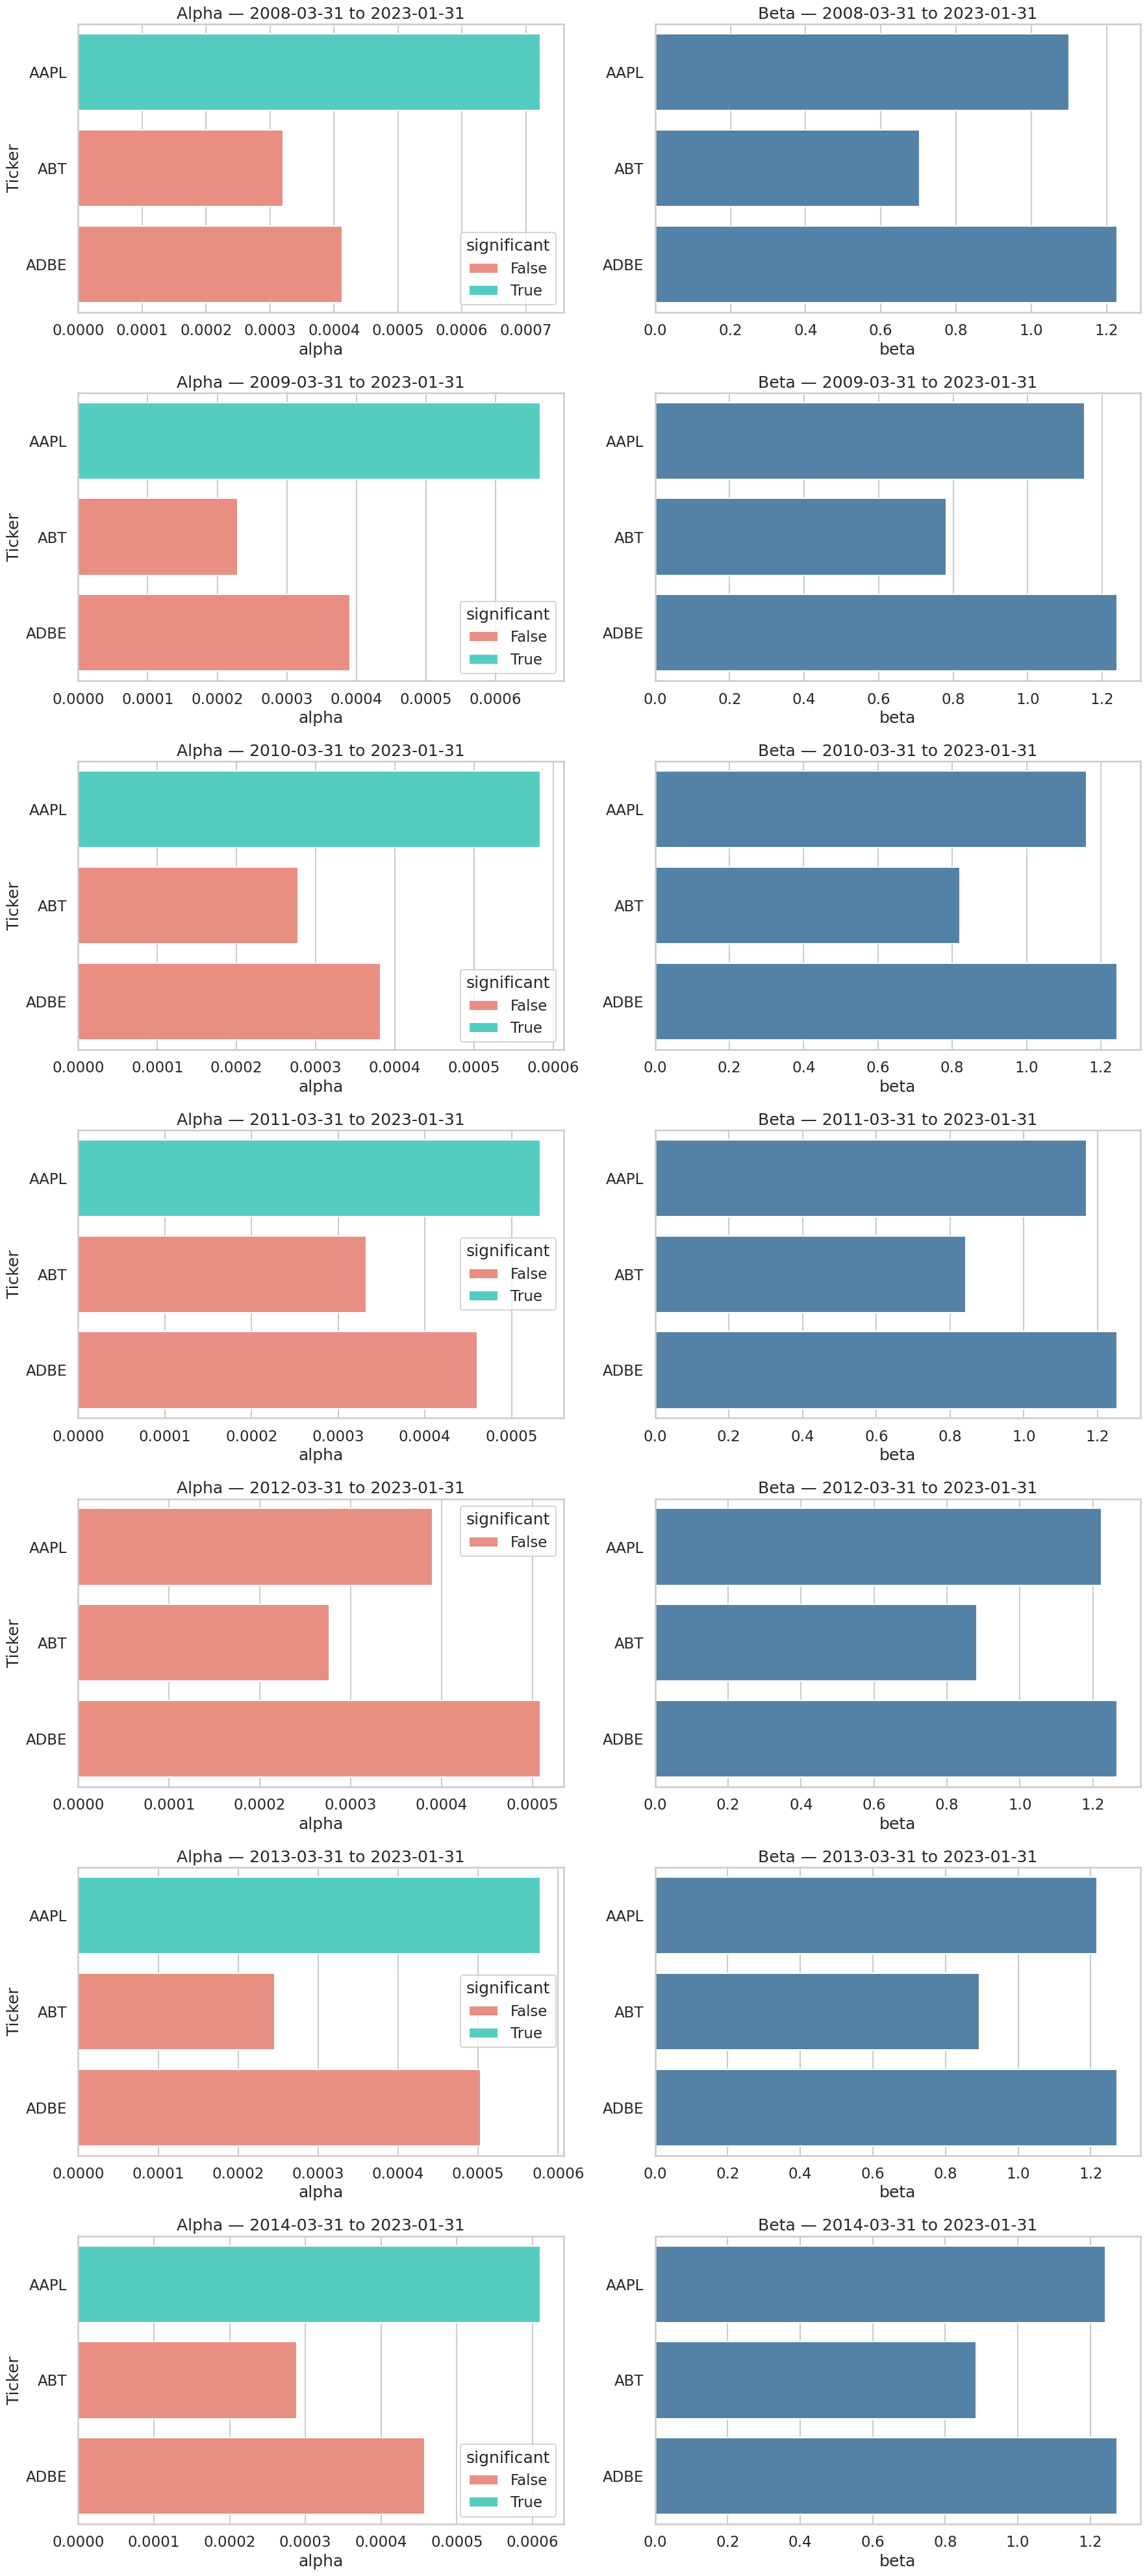

In [63]:
fig, axes = plt.subplots(7, 2, figsize=(18, 40))
plt.subplots_adjust(hspace=0.4)

for idx, start in enumerate(starts):
    first = excel_first_pass(RP_aligned, start, END)
    first = first.dropna()
    top3 = first.iloc[:3].copy()

    # === Alpha significance ===
    RM = RP_aligned['OEX_rp'].loc[start:END]
    RM_mean = RM.mean()
    RM_var = RM.var(ddof=1)
    N = len(RM)

    top3['alpha_se'] = np.sqrt(top3['sigma2'] * (1 + (RM_mean**2)/RM_var) / N)
    top3['tstat'] = top3['alpha'] / top3['alpha_se']
    top3['pval'] = 2*(1 - tdist.cdf(np.abs(top3['tstat']), df=N-2))
    top3['significant'] = top3['pval'] < 0.05

    # === LEFT subplot: ALPHA ===
    ax1 = axes[idx, 0]
    sns.barplot(
        data=top3, x='alpha', y='Ticker',
        hue='significant',
        palette={True:'turquoise', False:'salmon'},
        ax=ax1
    )
    ax1.set_title(f"Alpha — {start} to {END}")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("Ticker")

    # === RIGHT subplot: BETA ===
    ax2 = axes[idx, 1]
    sns.barplot(
        data=top3, x='beta', y='Ticker',
        color='steelblue',
        ax=ax2
    )
    ax2.set_title(f"Beta — {start} to {END}")
    ax2.set_xlabel("beta")
    ax2.set_ylabel("")

plt.tight_layout()
plt.savefig("src/alpha-beta-multiwindow.svg")
plt.show()

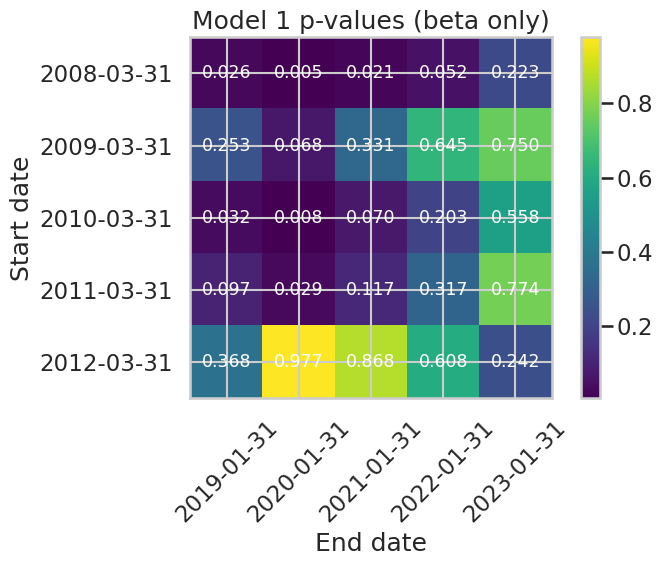

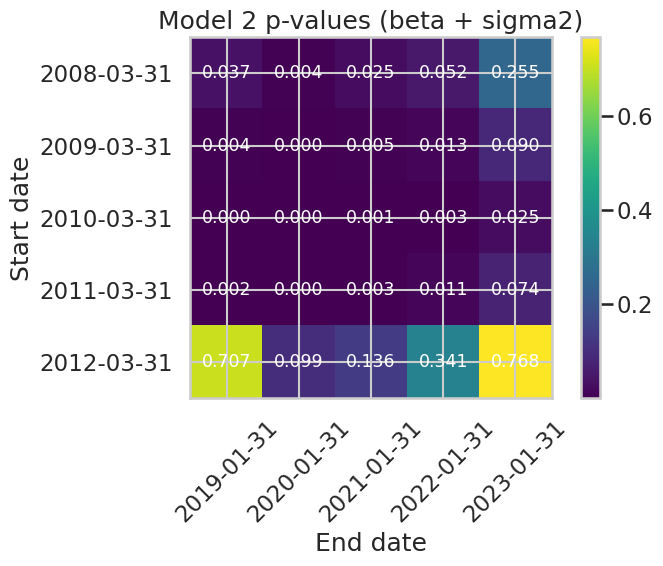

In [59]:
starts = [
    "2008-03-31",
    "2009-03-31",
    "2010-03-31",
    "2011-03-31",
    "2012-03-31"
]

ends = [
    "2019-01-31",
    "2020-01-31",
    "2021-01-31",
    "2022-01-31",
    "2023-01-31"
]

pvals1 = np.zeros((5,5))
pvals2 = np.zeros((5,5))

# === MAIN LOOP: 25 COMBINATIONS ===
for i, s in enumerate(starts):
    for j, e in enumerate(ends):

        first = excel_first_pass(RP_aligned, s, e)
        valid = first.set_index('Ticker').dropna()
        y = valid['riskprem_mean']

        # Model 1
        X1 = sm.add_constant(valid[['beta']])
        model1 = sm.OLS(y, X1).fit()

        # Model 2
        X2 = sm.add_constant(valid[['beta','sigma2']])
        model2 = sm.OLS(y, X2).fit()

        market_rp = RP_aligned['OEX_rp'].loc[s:e].mean()
        n = valid.shape[0]

        # Model 1 p-value
        gamma1_1 = model1.params['beta']
        se1 = model1.bse['beta']
        df1 = n - 2
        t1 = (gamma1_1 - market_rp)/se1
        p1 = 2*(1 - tdist.cdf(abs(t1), df1))

        # Model 2 p-value
        gamma1_2 = model2.params['beta']
        se2 = model2.bse['beta']
        df2 = n - 3
        t2 = (gamma1_2 - market_rp)/se2
        p2 = 2*(1 - tdist.cdf(abs(t2), df2))

        pvals1[i,j] = p1
        pvals2[i,j] = p2

# === HEATMAP FUNCTION ===
def plot_heatmap(mat, title):
    plt.figure(figsize=(8,6))
    im = plt.imshow(mat, cmap='viridis')
    plt.colorbar(im)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f'{mat[i,j]:.3f}', ha='center', va='center', color='white', size='x-small')
    plt.title(title)
    plt.xticks(range(5), [e[:10] for e in ends], rotation=45)
    plt.yticks(range(5), [s[:10] for s in starts])
    plt.xlabel("End date")
    plt.ylabel("Start date")
    plt.tight_layout()
    plt.show()

# === PRODUCE HEATMAPS ===
plot_heatmap(pvals1, "Model 1 p-values (beta only)")
plot_heatmap(pvals2, "Model 2 p-values (beta + sigma2)")


In [43]:
# === LOAD DATA ===
df = pd.read_csv(r'data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Resample prices to week-end (last available price in each week)
prices_m = df.drop(columns=['TB1M']).resample('W-FRI').last()

# Resample TB1M to week-end
rf_yield = df['TB1M'].resample('W-FRI').last()   # TB1M is an annualized % yield

# Convert TB1M to monthly risk-free return
# If TB1M is annualized simple yield (common), weekly RF ≈ yield/12
rf_m = (rf_yield / 100) / 52                 # weekly risk-free rate
rf_m_lag = rf_m.shift(1)

# ============================
# === MONTHLY RETURNS      ===
# ============================

# Simple weekly returns
returns_m = prices_m / prices_m.shift(1) - 1

# Risk premia
RP_m = returns_m.sub(rf_m_lag, axis=0).rename(columns={'OEX': 'OEX_rp'})

# Drop NA
RP_m_aligned = RP_m.dropna(how='any')

RP_m_aligned.head()

,OEX_rp,AAPL,ABT,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-14,0.016872,0.008387,-0.024426,0.023097,0.040632,0.241273,0.003561,0.221410,-0.077405,0.045296,...,-0.009509,0.146572,0.004062,0.015518,0.039455,0.071011,-0.043542,0.064461,-0.059429,-0.015016
2000-01-21,-0.023284,0.107237,-0.097055,-0.052878,-0.089808,-0.062960,0.092281,0.130107,-0.035087,-0.050021,...,-0.013861,0.026045,-0.053779,-0.051244,-0.027284,-0.068245,0.065553,-0.122480,-0.033017,0.013885
2000-01-28,-0.054580,-0.088082,0.020992,-0.085545,-0.019693,-0.070359,-0.201889,-0.124240,-0.007094,0.042211,...,0.124489,-0.033823,-0.099553,-0.072481,-0.035438,0.024884,-0.041635,0.056969,-0.118169,-0.073111
2000-02-04,0.049683,0.061645,0.079306,0.284473,-0.013342,0.092885,0.081636,0.068335,0.272470,0.019056,...,0.071990,0.231119,0.077298,-0.008778,-0.132944,0.001723,0.015183,-0.000482,0.020456,0.024270
2000-02-11,-0.031354,0.005853,-0.013795,0.221038,-0.060023,0.178812,-0.032038,0.093190,-0.031321,-0.050258,...,-0.076359,0.041524,-0.014306,-0.089463,-0.023263,-0.006693,-0.044848,-0.018919,-0.005530,-0.082524
